# Assignment
A cosmological [experiment](https://arxiv.org/abs/0907.3149) provides a measurement of the expansion history of the Universe, $H(z)$, obtained from the ages of passively-evolving galaxies in galaxy clusters at various redshifts, z. These measurements of $H(z)$ can be used to constrain the Hubble parameter $H_0$, quantifying the local expansion rate, and the matter density in the Universe, $\Omega_m$, using the following model:
$H(z) = H_0 \sqrt{\Omega_m(1 + z)^3 + (1 − \Omega_m)}$

We have, data provided by the measurements of $H(z)$ = $D$, 

parameters of the model = $H_0, \Omega_m$

prior probability = $p(D|H_0, \Omega_m)$

likelihood = $p(H_0, \Omega_m)$

posterior probability = $p(H_0, \Omega_m | D) \propto$ $p(D|H_0, \Omega_m) p(H_0, \Omega_m)$


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def data_loader(path):
    return np.loadtxt("Hz_BC03_all.dat", unpack=True)

In [3]:
def model(z, H0, omega_m):
    return H0 * np.sqrt(omega_m*(1+z)**3 + (1-omega_m))

In [4]:
z, H, Herr = data_loader(path="Hz_BC03_all.dat")
print(f"redshift: {z}, \nlocal expansion rate: {H}, \nlocal expansion rate error: {Herr}")

redshift: [0.09  0.17  0.179 0.199 0.27  0.352 0.4   0.48  0.593 0.68  0.781 0.875
 0.88  0.9   1.037 1.3   1.43  1.53  1.75 ], 
local expansion rate: [ 69.  83.  75.  75.  77.  83.  95.  97. 104.  92. 105. 125.  90. 117.
 154. 168. 177. 140. 202.], 
local expansion rate error: [12.  8.  4.  5. 14. 14. 17. 62. 13.  8. 12. 17. 40. 23. 20. 17. 18. 14.
 40.]


#### 1. Plot the measurements with their error bars along a handful of parameter combinations for the $H(z)$ model, some similar to the data, some different.

In [5]:
def error_plot(z, H):
    plt.figure(figsize=(10, 6))
    plt.errorbar(z, H, yerr=Herr, fmt='o', color='blue', ecolor='lightblue', elinewidth=3, label="Data")

    #Add other models as well to see the deviations in data and model
    H_model0 = model(z, H0=67.4, omega_m=0.315)
    plt.plot(z, H_model0,  'r-.', label=r"Model($H_0$=67.4, $\Omega_m$=0.315)")

    H_model1 = model(z, H0=70, omega_m=0.3)
    plt.plot(z, H_model1,  'r-', label=r"Model($H_0$=70, $\Omega_m$=0.3)")

    H_model2 = model(z, H0=100, omega_m=0.2)
    plt.plot(z, H_model2,  'r--', label=r"Model($H_0$=100, $\Omega_m$=0.2)")

    plt.xlabel('Redshift (z)', fontsize=12)
    plt.ylabel('H(z) [km/s/Mpc]', fontsize=12)
    plt.title('Hubble Parameter vs Redshift with Error Bars', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    plt.tight_layout()
    plt.show()

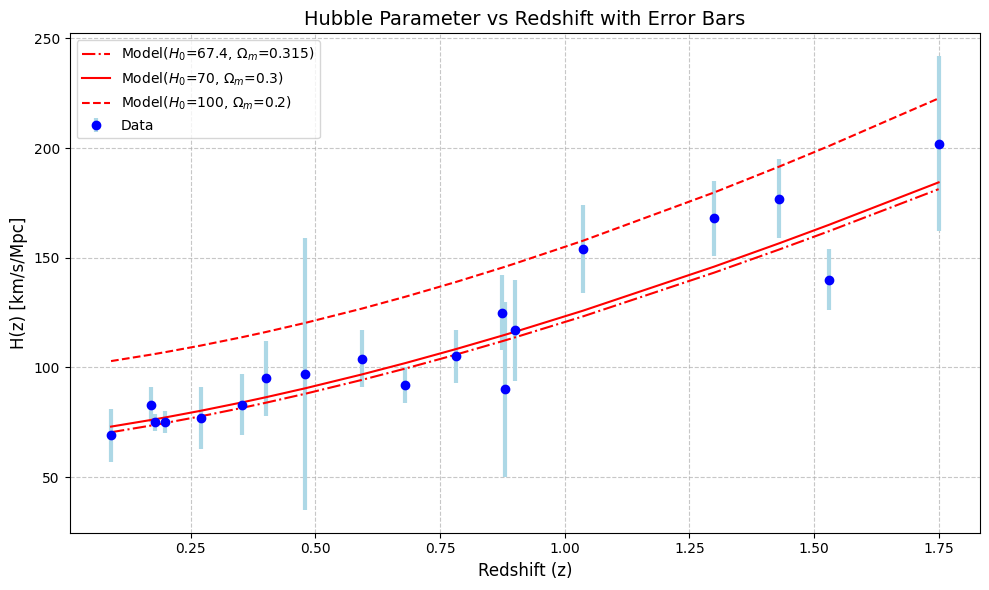

In [6]:
error_plot(z, H)

For the likelihood, $p(D|H_0, \Omega_m)$, we can assume a Gaussian likelihood, given the measurement uncertainties (`Herr`) that are provided in the data. In the case of this example, the data is composed of $H_i$ measurements at different $z_i$ s, with uncertainties $\sigma_i$ s respectively. The Gaussian likelihood is then be computed as

$p(D|H_0, \Omega_m) = \prod_{i=1} p(D_i|H_0, \Omega_m) = \prod_{i=1} e^{\frac{-(H_i − H(z_i, H_0, \Omega_m))^2}{\sigma^2_i}}$

where $H(z_i, H_0, \Omega_m)$ is the evaluation of the model (normalization constant) at $z_i$.

The Gaussian likelihood can also be written as,

$p(D|H_0, \Omega_m) = e^{\frac{-\chi^2}{2}}$

where, $ \chi^2 = \sum_i {\frac{(H_i − H(z_i, H_0, \Omega_m))^2}{\sigma^2_i}}$

#### 2. Define python functions for the model, the posterior (likelihood times prior) and the proposal distribution. For the prior distribution on the parameters, you can start by using a uniform prior over $50 < H_0 < 100$ and $0 < \Omega_m < 1$

In [16]:
def likelihood_chi_sq(z, H, herr, H0, omega_m):
    """chi-square likelihood"""
    chi_sq = 0 
    for i in range(len(z)):
        chi_sq += (H[i] - model(z[i], H0, omega_m)**2)/herr[i]**2
    return -chi_sq/2

In [17]:
def get_priors(H0, omega_m, H_low=50, H_up=100, omega_low=0, omega_up=1):
    """Initialization of priors for H0 and omega_m parameters as unfiorm distribution"""
    H0 = 1 if H_low < H0 < H_up else 0
    omega_m = 1 if omega_low < omega_m < omega_up else 0
    return H0, omega_m

In [18]:
def posterior(z, H, herr, H0, omega_m):
    """posterior probability based on likelihood and priors"""
    prior_H0, prior_omega = get_priors(H0, omega_m)
    likelihood = likelihood_chi_sq(z, H, herr, H0, omega_m)
    return likelihood * prior_H0 * prior_omega

In [30]:
def proposal(H0, omega_m, prop_width_H0=2.0, prop_width_omega_m=0.5):
    """Generate proposal for new parameter values"""
    H0_prop = np.random.normal(H0, prop_width_H0)
    omega_m_prop = np.random.normal(omega_m, prop_width_omega_m)
    omega_m_prop = np.clip(omega_m_prop, 0, 1) #omega is always within [0,1]
    
    return H0_prop, omega_m_prop

In [31]:
def metropolis_hastings(z, H, Herr, Nsim=10**4):
    """
    MCMC simulation using Metropolis-Hastings algorithm for cosmological model
    """
    chain = np.zeros((Nsim, 3))  # H0, omega_m, posterior
    
    H0_init = 70  # Initial guess for H0
    omega_m_init = 0.3  # Initial guess for omega_m
    
    chain[0] = H0_init, omega_m_init, posterior(z, H, Herr, H0_init, omega_m_init)
    count_accepted = 0
    
    for i in range(1, Nsim):
        H0_prop, omega_m_prop = proposal(chain[i-1, 0], chain[i-1, 1])
        post_prop = posterior(z, H, Herr, H0_prop, omega_m_prop)
        
        ratio = post_prop / chain[i-1, 2]
        if ratio >= 1 or ratio > np.random.random():
            chain[i] = H0_prop, omega_m_prop, post_prop
            count_accepted += 1
        else:
            chain[i] = chain[i-1]
    
    print(f"Acceptance rate: {count_accepted / Nsim:.2%}")
    
    return chain


In [32]:
chain = metropolis_hastings(z, H, Herr)
chain[1]

Acceptance rate: 50.58%


array([6.96693321e+01, 5.33200258e-01, 1.00613339e+03])

In [33]:
def plot_markov_chain(chain, burnin_period=10, remove_burnin=True):
    if remove_burnin:
        chain = chain[burnin_period:]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Visualize each dimension of the chain
    ax1.plot(chain[:,1], color='lightskyblue', lw=2, alpha=0.9, label=r'$x_2$')
    ax1.plot(chain[:,0], color='darkslategrey', lw=2, alpha=0.7, label=r'$x_1$')
    ax1.set_xlabel(r'Chain step')
    ax1.axvspan(0, burnin_period, color='tomato', alpha=0.1, label='Burn-in')
    ax1.legend(frameon=True)
    ax1.set_xscale('log')
    ax1.set_title('Markov Chain Progression')

    # Visualize chain as Gaussian
    ax2.scatter(chain[:,0], chain[:, 1], s=0.1, color='darkslategrey', alpha=0.7)
    ax2.set_xlabel(r'$x_1$')
    ax2.set_ylabel(r'$x_2$')
    ax2.set_title(r'Sampling of 2D Gaussian')

    plt.tight_layout()
    plt.show()

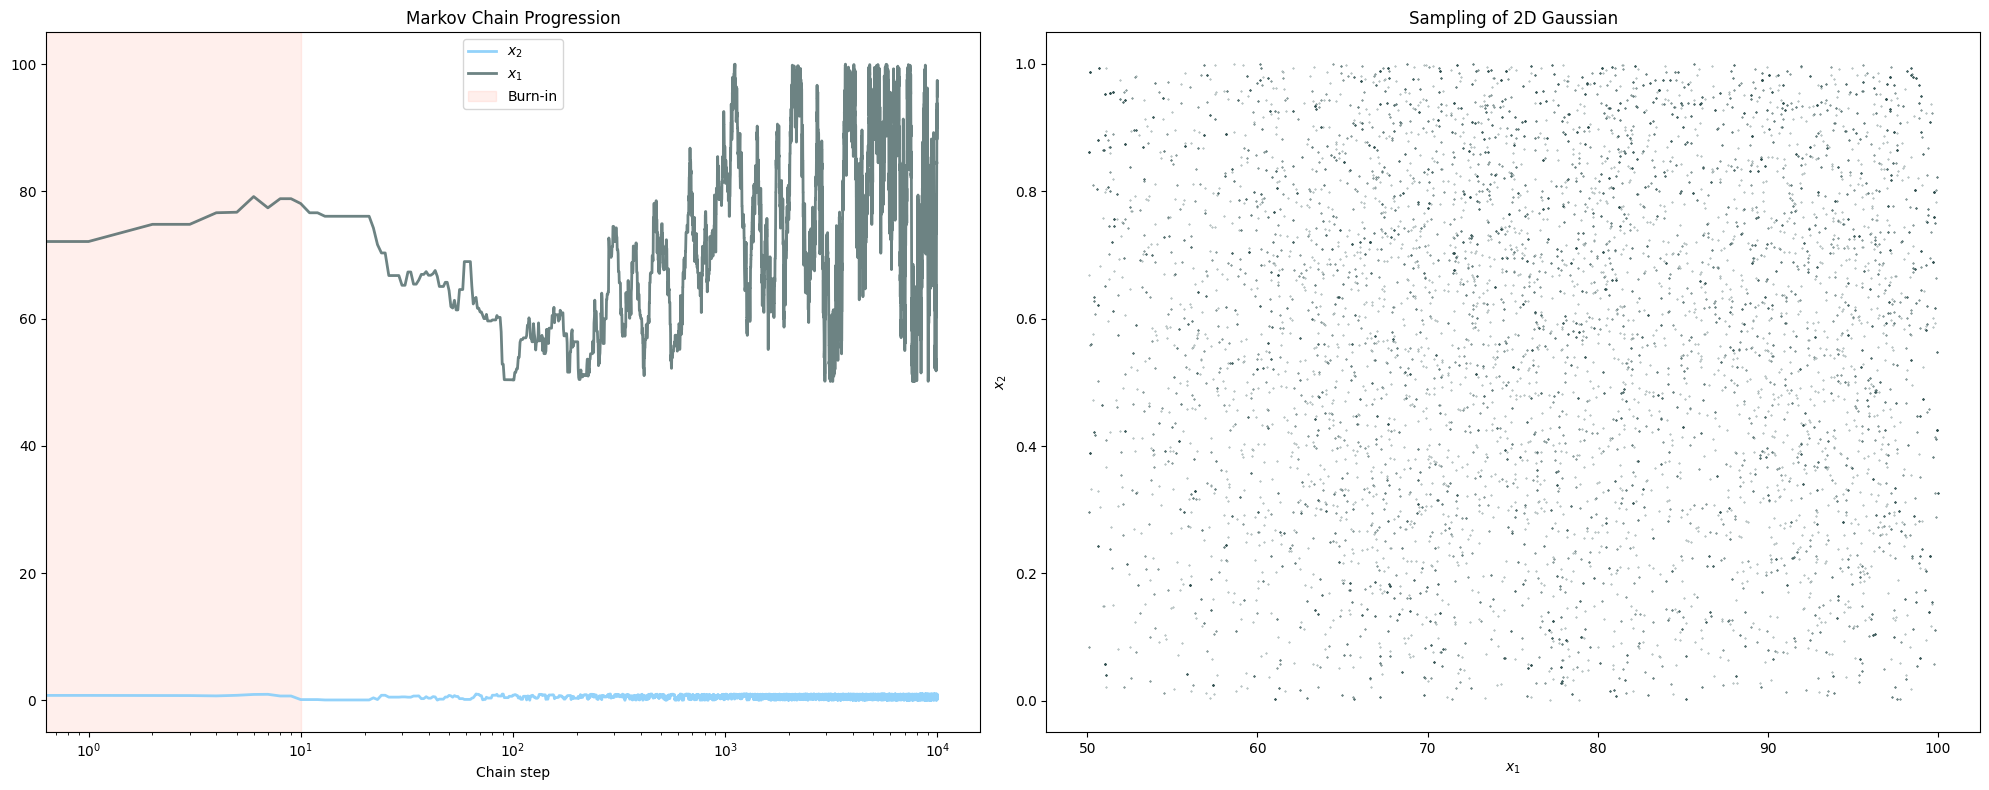

In [34]:
plot_markov_chain(chain)